In [1]:
from crypto_volatility_lab.data_construction import CryptoScraper, TimeSeriesCreator
import matplotlib.pyplot as plt
import pandas as pd
from arch import arch_model
import numpy as np

c:\Users\emmae\OneDrive\Documents\M2\Projet Finance\crypto-volatility-lab\.venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
crypto_scraper = CryptoScraper()
bitcoin_data = crypto_scraper.get_data_for_currency('BTC-USD')

In [3]:
print(bitcoin_data.shape)
bitcoin_data.head()

(3756, 7)


,Date,Open,High,Low,Close,Adj,Volume
0,"Dec 28, 2024","94,145.27","95,094.09","94,027.41","94,271.86","94,271.86","31,983,861,760"
1,"Dec 27, 2024","95,704.98","97,294.84","93,310.74","94,164.86","94,164.86","52,419,934,565"
2,"Dec 26, 2024","99,297.70","99,884.57","95,137.88","95,795.52","95,795.52","47,054,980,873"
3,"Dec 25, 2024","98,675.91","99,478.75","97,593.47","99,299.20","99,299.20","33,700,394,629"
4,"Dec 24, 2024","94,684.34","99,404.06","93,448.02","98,676.09","98,676.09","47,114,953,674"


In [4]:
ts_creator = TimeSeriesCreator(data=bitcoin_data, date_column_name='Date', value_column_name='Close')
log_returns = ts_creator.create_log_return_time_series()
volatility = ts_creator.create_volatility_time_series()

bitcoin_data["Log Returns"] = log_returns
# retransform log returns to normal returns
bitcoin_data["Volatility"] = volatility

bitcoin_data.tail()

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility
4,2024-12-21,"97,756.20","99,507.10","96,426.52",97224.73,"97,224.73","51,765,334,294",-0.005449,0.024611
3,2024-12-22,"97,218.32","97,360.27","94,202.19",95104.94,"95,104.94","43,147,981,314",-0.022044,0.025005
2,2024-12-23,"95,099.39","96,416.21","92,403.13",94686.24,"94,686.24","65,239,002,919",-0.004412,0.024827
1,2024-12-24,"94,684.34","99,404.06","93,448.02",98676.09,"98,676.09","47,114,953,674",0.041274,0.026458
0,2024-12-25,"98,675.91","99,478.75","97,593.47",99299.20,"99,299.20","33,700,394,629",0.006295,0.025756


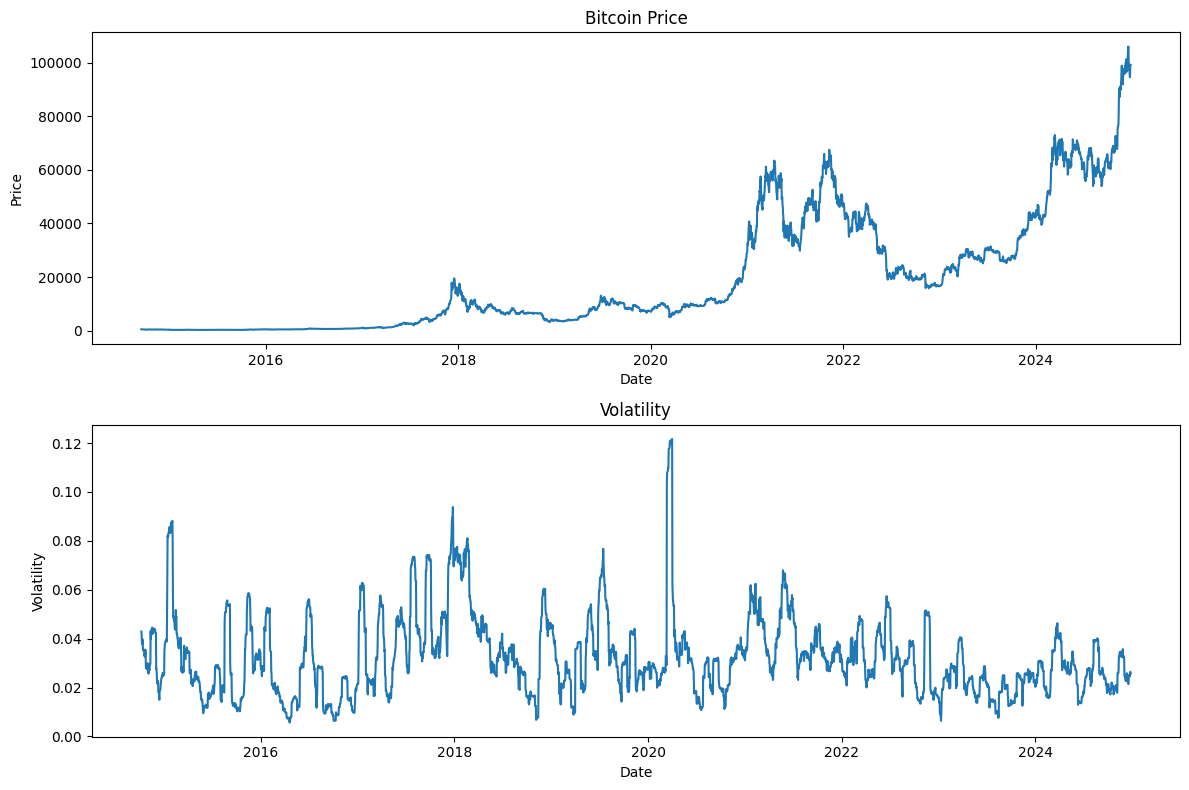

In [5]:
# sort the data by descending date
bitcoin_data = bitcoin_data.sort_values(by="Date", ascending=True)

# plotting time series by date
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(bitcoin_data["Date"], bitcoin_data["Close"])
ax[0].set_title("Bitcoin Price")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")

ax[1].plot(bitcoin_data["Date"], bitcoin_data["Volatility"])
ax[1].set_title("Volatility")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Volatility")

plt.tight_layout()
plt.show()

In [6]:
features = ts_creator.create_time_series_for_NN_training()
features.head()

c:\Users\emmae\OneDrive\Documents\M2\Projet Finance\crypto-volatility-lab\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


,Log Returns,Volatility,GARCH Volatility,Volatility Weekly,Volatility Monthly,Date
0,0.006295,0.025756,0.028158,0.025196,0.026000,2024-12-25
1,0.041274,0.026458,0.026340,0.024987,0.026317,2024-12-24
2,-0.004412,0.024827,0.027455,0.024271,0.026521,2024-12-23
3,-0.022044,0.025005,0.027598,0.023840,0.026789,2024-12-22
4,-0.005449,0.024611,0.028798,0.023840,0.027040,2024-12-21


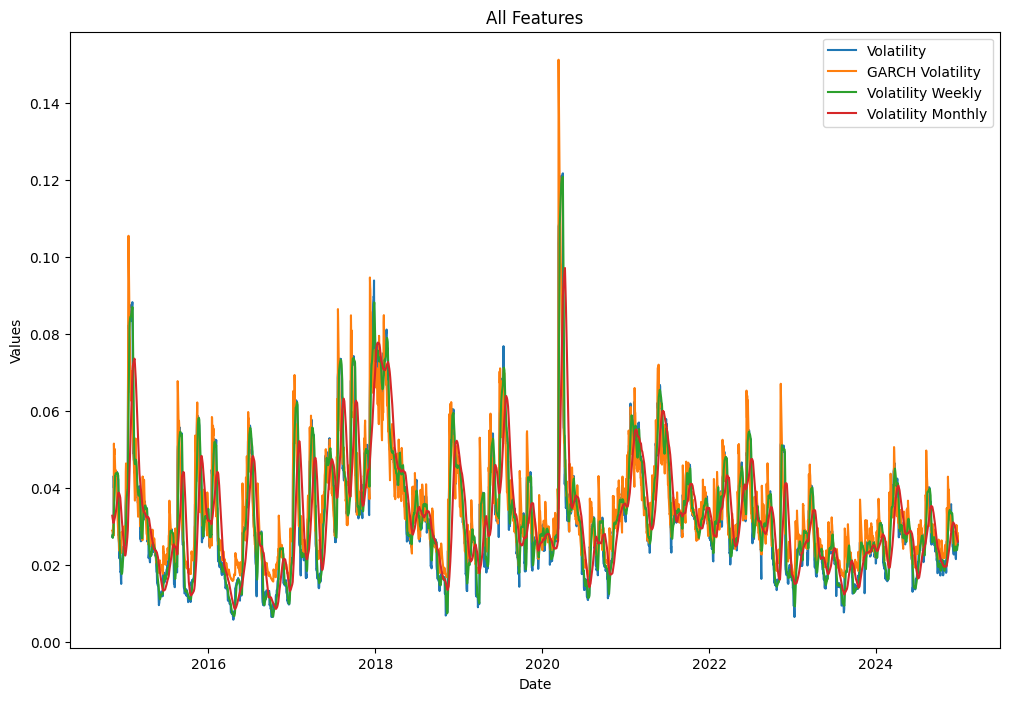

MSE between Volatility and GARCH Volatility: 4.396153317452553e-05
MAPE between Volatility and GARCH Volatility: 0.19463269594219962


In [7]:
# plot all features on the same graph
plt.figure(figsize=(12, 8))

plt.plot(features["Date"], features["Volatility"], label="Volatility")
plt.plot(features["Date"], features["GARCH Volatility"], label="GARCH Volatility")
plt.plot(features["Date"], features["Volatility Weekly"], label="Volatility Weekly")
plt.plot(features["Date"], features["Volatility Monthly"], label="Volatility Monthly")

plt.title("All Features")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

#mse between the volatility and the GARCH volatility
mse = ((features["Volatility"] - features["GARCH Volatility"]) ** 2).mean()
print(f"MSE between Volatility and GARCH Volatility: {mse}")

# mape between the volatility and the GARCH volatility
mape = (abs(features["Volatility"] - features["GARCH Volatility"]) / features["Volatility"]).mean()
print(f"MAPE between Volatility and GARCH Volatility: {mape}")

In [9]:
# Fenêtre glissante pour l'entraînement et le test
in_sample_period = 100
out_sample_period = 5

results = []

for start in range(0, len(features) - in_sample_period - out_sample_period + 1, out_sample_period):
    # Définir les ensembles d'entraînement et de test
    train = features.iloc[start:start + in_sample_period]
    test = features.iloc[start + in_sample_period:start + in_sample_period + out_sample_period]

    # Modèle simple de régression (peut être remplacé par un modèle plus complexe)
    from sklearn.linear_model import LinearRegression

    X_train = train[['Volatility', 'GARCH Volatility', 'Volatility Weekly', 'Volatility Monthly']]
    y_train = train['Volatility']
    X_test = test[['Volatility', 'GARCH Volatility', 'Volatility Weekly', 'Volatility Monthly']]
    y_test = test['Volatility']

    # Entraîner le modèle
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Prédire sur la période out-of-sample
    predictions = model.predict(X_test)

    # Évaluer les performances (par exemple : MSE)
    mse = np.mean((y_test - predictions) ** 2)
    results.append({
        'start_date': train.index[0],
        'end_date': test.index[-1],
        'mse': mse
    })

# Résultats globaux
results_df = pd.DataFrame(results)
print("Performance moyenne (MSE) :", results_df['mse'].mean())

Performance moyenne (MSE) : 1.2745326233097007e-34
